<a href="https://colab.research.google.com/github/Bappy60/ML_Assignment/blob/main/Final%20Lab%20Problem%202/Predicting_Customer_Behaviour_Using_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Author Name : Kawsar Ahemmed Bappy*

*Registration Number : 2018831060*

#Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import Counter
!pip install google-colab
import google.colab.drive as drive

#Mounting Drive & Downloading Zip file

In [ ]:
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/bank-data.zip"

In [ ]:
!ls -l

In [ ]:
!ls -l bank-data/

#Loading the Dataset

In [ ]:
df = pd.read_csv('bank-data/bank-full.csv',sep=';')

#Exploaring Data

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
#  Find missing values of each feature in the data set.
df.info()

In [ ]:
# statistical aspects of the dataframe
df.describe(include='all')

In [ ]:
df.nunique()

#Preprocessing

Here are steps we follow to preprocess our data:

1. Dealing with missing values
2. Splitting of data (80 : 20 split)
3. Handling Categorical Variable
4. Oversampling using SMOTE
5. Random Feature Elimination (RFE)
Logistic Regression Model Fitting

##Dealing with missing values

In [ ]:
#checking for missing values
df.isnull().sum()

Luckily, our dataset does not contain missing data. Hence, we can skip this step.

##Experiment

In [ ]:
# # Drop the 'poutcome' column from the dataset
# df = df.drop(columns=['poutcome'])

In [ ]:
# # Calculate the percentage of 'unknown' values in each column
# unknown_percentages = (df == 'unknown').mean() * 100

# # Calculate the percentage of 'unknown' values in each row
# unknown_percentages_in_rows = (df == 'unknown').mean(axis=1) * 100

# # Find the column with the highest percentage of 'unknown' values
# column_with_highest_percentage = unknown_percentages.idxmax()
# highest_percentage_column = unknown_percentages.max()

# # Find the row with the highest percentage of 'unknown' values
# row_with_highest_percentage = unknown_percentages_in_rows.idxmax()
# highest_percentage_row = unknown_percentages_in_rows.max()

# # Print the results
# print("Percentage of 'unknown' values in each column:")
# print(unknown_percentages)
# print("\nPercentage of 'unknown' values in each row:")
# print(unknown_percentages_in_rows)
# print("\nColumn with the highest percentage of 'unknown' values:")
# print(f"Column: {column_with_highest_percentage}, Percentage: {highest_percentage_column:.2f}%")
# print("\nRow with the highest percentage of 'unknown' values:")
# print(f"Row: {row_with_highest_percentage}, Percentage: {highest_percentage_row:.2f}%")


In [ ]:
#droping the 4th row as it has the highest percentage of unknown values
# data = df.drop(4)

In [ ]:
# # Calculate the count of 'unknown' and 'other' in the 'poutcome' column
# unknown_count = (df['poutcome'] == 'unknown').sum()
# other_count = (df['poutcome'] == 'other').sum()

# # Calculate the total count of values in the 'poutcome' column
# total_count = len(df)

# # Calculate the percentage of 'unknown' and 'other'
# percentage_unknown = (unknown_count / total_count) * 100
# percentage_other = (other_count / total_count) * 100

# print("Percentage of 'unknown' in poutcome:", percentage_unknown)
# print("Percentage of 'other' in poutcome:", percentage_other)


Droping the column: If a column has too many ‘unknown’ or ‘other’ values, it might not be very useful for the model. Thats why i am dropping the column entirely.

##Splitting of data (80 : 20 split)

In [ ]:
# load X and y
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

##Handling Categorical *variable*

In [ ]:
cat_col = [n for n  in df.columns if df[n].dtypes == 'object']
for col in cat_col:
  print(col, '\n\n')
  print(df[col].value_counts())
  print("〰"*25)
  print('\n')

In [ ]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.values
numeric_features = numeric_features[numeric_features != 'y']

category_features = X_train.select_dtypes(include=['object', 'bool']).columns.values

print(numeric_features)
print(category_features)

In [ ]:
def dummify(ohe, x, columns):
    transformed_array = ohe.transform(x)

    # list of category columns
    enc = ohe.named_transformers_['cat'].named_steps['onehot']
    feature_lst = enc.get_feature_names_out(category_features.tolist())

    cat_colnames = np.concatenate([feature_lst]).tolist()
    all_colnames = numeric_features.tolist() + cat_colnames

    # convert numpy array to dataframe
    df = pd.DataFrame(transformed_array, index = x.index, columns = all_colnames)

    return transformed_array, df

In [ ]:
# impute missing numerical values with a median value, then scale the values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# impute missing categorical values using the 'missing' and one hot encode the categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Each transformer is a three-element tuple that defines
#                                 the name of the transformer,
#                                 the transform to apply,
#                                 and the column features to apply it to
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, category_features)])

ohe = preprocessor.fit(X_train)

X_train_t = ohe.transform(X_train)
X_test_t = ohe.transform(X_test)

In [ ]:
# transform training and test set and then convert it to dataframe
X_train_t_array, X_train_t = dummify(ohe, X_train, category_features)
X_test_t_array, X_test_t = dummify(ohe, X_test, category_features)

X_train_t.head()

In [ ]:
X_train_columns = X_train_t.columns
print(X_train_columns)

##Oversampling using SMOTE

Input values:    
* Dataframe: X_train_t, y_train, X_test_t, y_test
    
* Array: X_train_t_array, X_test_t_array

In [ ]:
# Calculate the count of 'yes' and 'no' in the 'y' column
yes_count = (df['y'] == 'yes').sum()
no_count = (df['y'] == 'no').sum()

# Calculate the total count of values in the 'y' column
total_count = len(df)

# Calculate the percentage of 'yes' and 'no'
percentage_yes = (yes_count / total_count) * 100
percentage_no = (no_count / total_count) * 100
print("before sampling")
print("Percentage of 'yes' in 'y':", percentage_yes)
print("Percentage of 'no' in 'y':", percentage_no)

As mentioned above, our data is imbalanced. We can see that in our dataset, the positive samples (minority class) are much less than negative samples (majority class). The positive samples (the people who subscribed to the term deposit) were only 11.69% from the total samples. Therefore, accuracy is no longer a good measure of performance because if we simply predict all examples to the negative class, we achieve 88.3% accuracy. As a result, we need to apply methods to overcome class imbalance problem. In this section, we use SMOTE method to balance our dataset.

SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together.

 We define a SMOTE instance with default parameters that will balance the minority class and then fit and apply it in one step to create a transformed version of our dataset.


In [ ]:
from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(y_train)
print(counter)

# transform the dataset
oversample = SMOTE()
X_train_smote, y_train = oversample.fit_resample(X_train_t, y_train)

# summarize the new class distribution
counter = Counter(y_train)
print(counter)

## Random Feature Elimination (RFE)

RFE is a popular feature selection algorithm. It is easy to configure and pretty effective at selecting features in a training dataset. There are two important configuration options when using RFE:

    1. The number of features to select.
    
    2. The choice of algorithm used to help choose features.

In [65]:
from sklearn.svm import SVC

final_X_train = pd.DataFrame(data=X_train_smote,columns=X_train_columns )
final_y_train = pd.DataFrame(data=y_train,columns=['y'])

rfe_model = RFE(LogisticRegression(solver='lbfgs'), n_features_to_select=25)
rfe_model = rfe_model.fit(final_X_train, final_y_train)

# feature selection
print(rfe_model.support_)
print(rfe_model.ranking_)

[False False False  True False False False False False False  True False
  True False False  True False False  True False False False  True False
 False False False  True  True False False  True  True  True  True False
  True  True False  True  True False  True  True  True  True  True  True
  True  True  True]
[27 25 23  1  5 26 22  7 18  9  1 20  1 10 19  1 24 17  1 15 14  6  1 21
  8 11 16  1  1  3  4  1  1  1  1 13  1  1  2  1  1 12  1  1  1  1  1  1
  1  1  1]


In [66]:
selected_columns = X_train_columns[rfe_model.support_]
print(selected_columns.tolist())

['duration', 'job_housemaid', 'job_retired', 'job_student', 'job_unknown', 'education_primary', 'default_yes', 'housing_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_jan', 'month_jul', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [67]:
X_train_final = final_X_train[selected_columns.tolist()]
y_train_final = final_y_train['y']
X_test_final = X_test_t[selected_columns.tolist()]
y_test_final = y_test

X_test_final.head()

,duration,job_housemaid,job_retired,job_student,job_unknown,education_primary,default_yes,housing_no,loan_yes,contact_cellular,...,month_jul,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
3776,-0.252612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9928,-0.676934,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
33409,-0.120255,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
31885,0.210638,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15738,-0.529005,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Logistic Regression Model Fitting

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(X_train_final, y_train_final)

LogisticRegression()

In [69]:
y_pred = logreg.predict(X_test_final)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_final, y_test_final)))

Accuracy of logistic regression classifier on test set: 0.84


Accuracy: 0.8417560544067234

Classification Report for Test Set:
              precision    recall  f1-score   support

          no       0.97      0.85      0.90      7952
         yes       0.42      0.82      0.55      1091

    accuracy                           0.84      9043
   macro avg       0.70      0.83      0.73      9043
weighted avg       0.90      0.84      0.86      9043


Confusion Matrix for Test Set:
[[6722 1230]
 [ 201  890]]


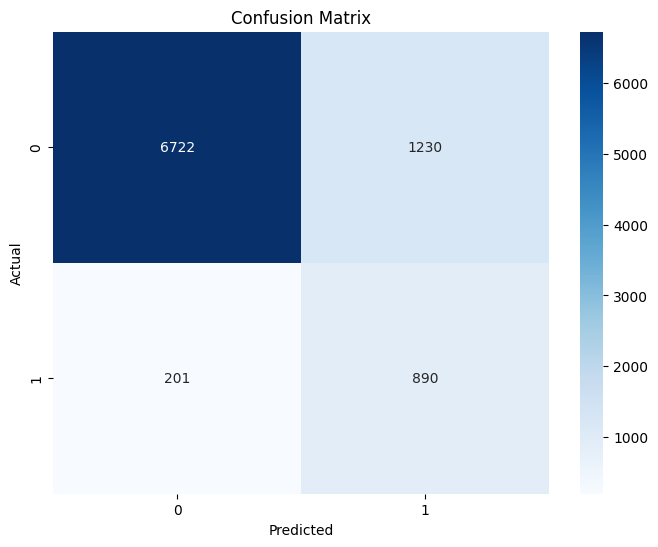

In [71]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Make predictions on the test set
y_pred = logreg.predict(X_test_final)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Use other metrics as needed (e.g., precision, recall, F1-score)
# Generate a classification report for the test set
print("\nClassification Report for Test Set:")
print(classification_report(y_test, y_pred))

# Generate a confusion matrix for the test set
print("\nConfusion Matrix for Test Set:")
print(confusion_matrix(y_test, y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()